### Importing libraries

In [2]:
import openpyxl as op
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import numpy as np
import pandas as pd
from openpyxl import Workbook
import re
from IPython.display import set_matplotlib_formats
from matplotlib.patches import Patch, PathPatch
import collections
import plotly.graph_objects as go
import os
import glob
import plotly.express as px
import statistics
from enum import auto

### Loading affected protein block summary table

In [4]:
pblocks = pd.read_excel('../B_hybrid_aln_results_toy/pblock-table/pblocks_hybrid_align_table.xlsx')

In [7]:
class CTerminalChange():
    SPLICING = auto()
    FRAMESHIFT = auto()
    ALTERNATIVE_ORF = auto()
    UNKNOWN = auto()

class NTerminalChange():
    MUTUALLY_EXCLUSIVE = auto()
    DOWNSTREAM_SHARED = auto()
    UPSTREAM_SHARED = auto()
    MUTUALLY_SHARED = auto()
    ALTERNATIVE_ORF = auto()
    UNKNOWN = auto()

In [9]:
cterm_pblocks = pblocks[~pblocks['cterm'].isna() & (pblocks['nterm'] != NTerminalChange.ALTERNATIVE_ORF) & (pblocks['cterm'] != CTerminalChange.ALTERNATIVE_ORF) & (pblocks['cterm'] != CTerminalChange.UNKNOWN)].copy()
cterm_pblocks['cterm'] = cterm_pblocks['cterm'].astype('category')
# Changed string to set for intersection
cterm_pblocks['APA'] = cterm_pblocks['events'].apply(lambda x: set(x).intersection('BbPp')).astype(bool)

display(pd.crosstab(cterm_pblocks['up_stop_cblock'], cterm_pblocks['down_stop_cblock'], margins=True))

down_stop_cblock,d,i,t,u,All
up_stop_cblock,,,,,
a,5,0,0,23,28
b,5,0,9,16,30
d,0,4,8,0,12
i,13,0,0,6,19
All,23,4,17,45,89


### Plot 1: Distribution of C-termini categories for alternative isoforms

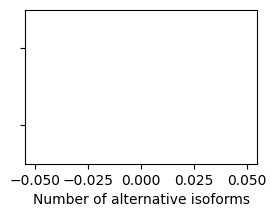

In [10]:

    cterm_splice_palette = sns.color_palette('RdPu_r', n_colors=3)
    cterm_frameshift_palette = sns.color_palette('YlOrRd_r', n_colors=4)
    cterm_palette = [cterm_splice_palette[0], cterm_frameshift_palette[0]]

    cterm_fig = plt.figure(figsize=(3, 2))
    ax = sns.countplot(
        data = cterm_pblocks,
        y = 'cterm',
        order = (CTerminalChange.SPLICING, CTerminalChange.FRAMESHIFT),
        palette = cterm_palette,
        saturation = 1,
        linewidth = 0,
    )
    ax.set(xlabel='Number of alternative isoforms', ylabel=None, yticklabels=[])
    plt.savefig('../E_cterm_plots/cterm-class-counts.svg', dpi=200, facecolor=None)

### Plot 2: 

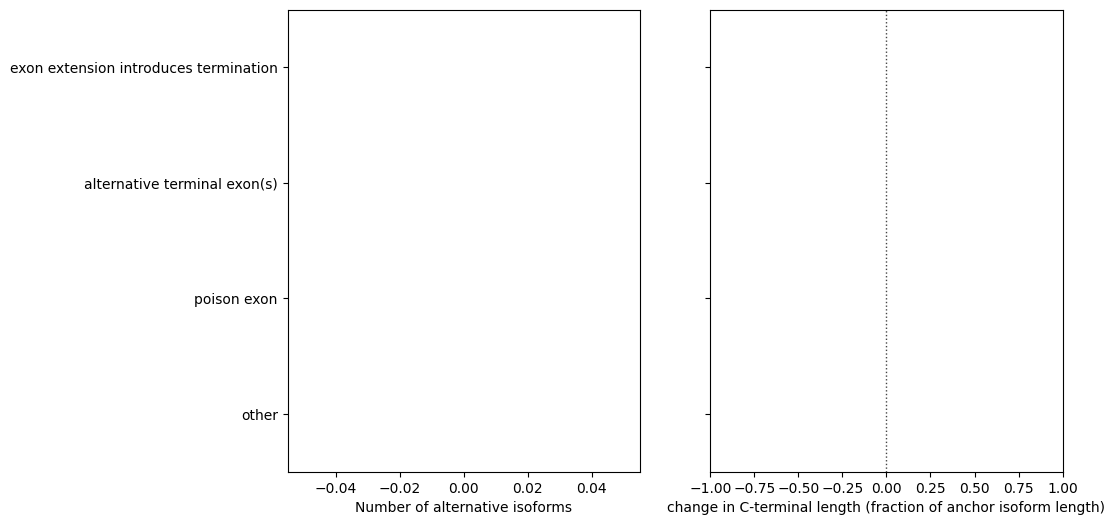

In [12]:
cterm_pblock_events = cterm_pblocks['up_stop_events'].combine(cterm_pblocks['down_stop_events'], lambda x, y: (x, y))
single_ATE = (cterm_pblocks['cterm'] == CTerminalChange.SPLICING) & cterm_pblocks['tblock_events'].isin({('B', 'b'), ('b', 'B')})
cterm_splice_subcats = pd.DataFrame(
    {
        'exon extension introduces termination': cterm_pblocks['up_stop_events'].isin({'P', 'I', 'D'}),
        'alternative terminal exon(s)': cterm_pblock_events.isin({('B', 'b'), ('b', 'B')}),
        'poison exon': cterm_pblocks['up_stop_events'] == 'E',
        'other': [True for _ in cterm_pblocks.index]
    }
)
cterm_pblocks['splice_subcat'] = cterm_splice_subcats.idxmax(axis=1).astype(pd.CategoricalDtype(cterm_splice_subcats.columns, ordered=True))

cterm_splice_palette_dict = dict(zip(
    cterm_splice_subcats.columns,
    cterm_splice_palette[0:1] + cterm_splice_palette[1:2] + cterm_splice_palette[2:3] + ['#bbbbbb']
))

# splice_subcat_order = cterm_pblocks[cterm_pblocks['cterm'] == CTerminalChange.SPLICING]['splice_subcat'].value_counts().index
splice_subcat_order = tuple(cterm_splice_subcats.keys())

cterm_splice_fig, axs = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(
    ax = axs[0],
    data = cterm_pblocks[cterm_pblocks['cterm'] == CTerminalChange.SPLICING],
    y = 'splice_subcat',
    order = splice_subcat_order,
    palette = cterm_splice_palette_dict,
    saturation = 1,
    linewidth = 0,
)
axs[0].set(xlabel='Number of alternative isoforms', ylabel=None)

sns.violinplot(
    ax = axs[1],
    data = cterm_pblocks[cterm_pblocks['cterm'] == CTerminalChange.SPLICING],
    x = 'anchor_relative_length_change',
    y = 'splice_subcat',
    order = splice_subcat_order,
    palette = cterm_splice_palette_dict,
    saturation = 1,
    gridsize = 200,
    scale = 'area',
)
xmax = max(axs[1].get_xlim())
ymin, ymax = axs[1].get_ylim()
axs[1].vlines(x=0, ymin=ymin, ymax=ymax, color='#444444', linewidth=1, linestyle=':')
axs[1].set(xlim=(-1, 1), ylim=(ymin, ymax), xlabel='change in C-terminal length (fraction of anchor isoform length)', ylabel=None, yticklabels=[])

plt.savefig('../E_cterm_plots//cterm-splicing-subcats.svg', dpi=200, facecolor=None, bbox_inches='tight')

### Plot 3: 

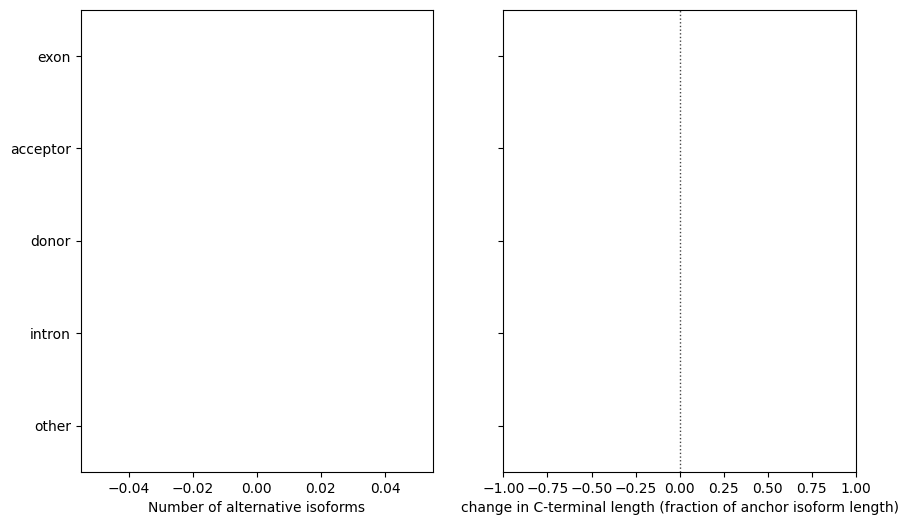

In [14]:
cterm_frame_subcats = pd.DataFrame(
    {
        'exon': cterm_pblocks['up_stop_cblock_events'].isin({'E', 'e'}),
        'acceptor': cterm_pblocks['up_stop_cblock_events'].isin({'A', 'a'}),
        'donor': cterm_pblocks['up_stop_cblock_events'].isin({'D', 'd'}),
        'intron': cterm_pblocks['up_stop_cblock_events'].isin({'I', 'i'}),
        'other': [True for _ in cterm_pblocks.index]
    }
)
cterm_pblocks['frame_subcat'] = cterm_frame_subcats.idxmax(axis=1).astype(pd.CategoricalDtype(cterm_frame_subcats.columns, ordered=True))

cterm_frameshift_palette_dict = dict(zip(
    cterm_frame_subcats.columns,
    cterm_frameshift_palette + ['#bbbbbb']
))

frame_subcat_order = cterm_pblocks[cterm_pblocks['cterm'] == CTerminalChange.FRAMESHIFT]['frame_subcat'].value_counts().index

cterm_frameshift_fig, axs = plt.subplots(1, 2, figsize=(10, 6))
sns.countplot(
    ax = axs[0],
    data = cterm_pblocks[cterm_pblocks['cterm'] == CTerminalChange.FRAMESHIFT],
    y = 'frame_subcat',
    order = frame_subcat_order,
    palette = cterm_frameshift_palette_dict,
    saturation = 1,
    linewidth = 0,
)
axs[0].set(xlabel='Number of alternative isoforms', ylabel=None)

sns.violinplot(
    ax = axs[1],
    data = cterm_pblocks[cterm_pblocks['cterm'] == CTerminalChange.FRAMESHIFT],
    x = 'anchor_relative_length_change',
    y = 'frame_subcat',
    order = frame_subcat_order,
    palette = cterm_frameshift_palette_dict,
    saturation = 1,
    scale = 'area'
)
xmax = max(axs[1].get_xlim())
ymin, ymax = axs[1].get_ylim()
axs[1].vlines(x=0, ymin=ymin, ymax=ymax, color='#444444', linewidth=1, linestyle=':')
axs[1].set(xlim=(-1, 1), ylim=(ymin, ymax), xlabel='change in C-terminal length (fraction of anchor isoform length)', ylabel=None, yticklabels=[])

plt.savefig('../E_cterm_plots/cterm-frameshift-subcats.svg', dpi=200, facecolor=None, bbox_inches='tight')

In [15]:

cterm_event_counts = cterm_pblocks.groupby('cterm').events.value_counts().rename('count')
cterm_examples = cterm_pblocks.groupby(['cterm', 'events']).sample(1, random_state=329).join(cterm_event_counts, on=['cterm', 'events']).sort_values(['cterm', 'count'], ascending=False).set_index(['cterm', 'events'])
